In [2]:
import cv2
import numpy as np

def image_loss(img_origin, img_cleaned):
      
    return img_origin - img_cleaned

def auto_params(img):
    mean = np.mean(img)
    std = np.std(img)
    contrast = np.percentile(img, 99) - np.percentile(img, 1)
    
    blur = 0
    kernels = []
    inpaint_radius = 0
    
    # image sombre
    if mean < 80:
        blur = (5, 5)
        kernels = [(1, 20), (20, 1)]
    # image clair
    elif mean < 170:
        blur = (3, 3)
        kernels = [(1, 12), (12, 1)]
    # contraste faible
    elif contrast < 60:
        blur = (3, 3)
        kernels = [(1, 25), (25, 1)]
    else:
        blur = (3, 3)
        kernels = [(1, 15), (15, 1)]
    
    # calcul du radius. Clip permet de limiter la valeur entre 2 et 5. Si resultat < 2 => 2, si > 5 => 5
    inpaint_radius = int(np.clip(std / 40, 3, 5))
    
    return blur, kernels, inpaint_radius



In [1]:
import cv2
import numpy as np
import os
from pathlib import Path

# Paths
PROJECT_ROOT = Path(os.getcwd())  # racine du projet
DATASET_ROOT = PROJECT_ROOT.parent / "data" # racine du dataset
DATASET_REP  = DATASET_ROOT / "COVID-19_Radiography_Dataset" # Répertoire contenant le dataset

img_name = "COVID-183.png"
img_path = DATASET_REP / "COVID" / "images" / img_name
mask_path = DATASET_REP / "COVID" / "masks" / img_name
    
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
resized_mask = cv2.resize(mask, img.shape, interpolation=cv2.NEIGH_FLANN_KNN)
    
masked_img = cv2.bitwise_and(img, resized_mask)
gray = cv2.normalize(masked_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
twilight = cv2.applyColorMap(gray, 1)

hsv = cv2.cvtColor(twilight, cv2.COLOR_BGR2HSV)

# Fonction callback vide pour trackbars
def nothing(x):
    pass

# Fenêtre et trackbars
cv2.namedWindow("HSV Adjustment")
cv2.createTrackbar("H min", "HSV Adjustment", 85, 179, nothing)
cv2.createTrackbar("H max", "HSV Adjustment", 150, 179, nothing)
cv2.createTrackbar("S min", "HSV Adjustment", 40, 255, nothing)
cv2.createTrackbar("S max", "HSV Adjustment", 255, 255, nothing)
cv2.createTrackbar("V min", "HSV Adjustment", 40, 255, nothing)
cv2.createTrackbar("V max", "HSV Adjustment", 255, 255, nothing)

while True:
    # Lecture des valeurs des trackbars
    h_min = cv2.getTrackbarPos("H min", "HSV Adjustment")
    h_max = cv2.getTrackbarPos("H max", "HSV Adjustment")
    s_min = cv2.getTrackbarPos("S min", "HSV Adjustment")
    s_max = cv2.getTrackbarPos("S max", "HSV Adjustment")
    v_min = cv2.getTrackbarPos("V min", "HSV Adjustment")
    v_max = cv2.getTrackbarPos("V max", "HSV Adjustment")

    lower_blue = np.array([h_min, s_min, v_min])
    upper_blue = np.array([h_max, s_max, v_max])

    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    # Overlay rouge pour visualiser les artefacts détectés
    overlay = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    overlay[mask_blue == 255] = [0, 0, 255]  # BGR rouge

    cv2.imshow("HSV Adjustment", overlay)

    # Quitter avec 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2570: error: (-27:Null pointer) NULL window: 'HSV Adjustment' in function 'cvGetTrackbarPos'


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_remove_artifacts(img, sigma=0.33, debug_mode= False):
    
    if debug_mode:
        plt.imshow(img, cmap = 'gray')
        plt.title("img")
        plt.show();
    
    # Calculer la médiane des pixels
    v = np.median(img)
    # recherche des paramètres en fonction de l'image
    _, _, inpaint_radius = auto_params(img)
    print(inpaint_radius)
    # Définir les seuils du canny min et max automatiquement
    canny_min = int(max(0, (1.0 - sigma) * v))
    canny_max = int(min(255, (1.0 + sigma) * v))

    # Détection des bords (filtre Canny)
    edges = cv2.Canny(img, canny_min, canny_max)
    if debug_mode:
        plt.imshow(edges, cmap = 'gray')
        plt.title("edges")
        plt.show();
    # Dilatation pour renforcer les bords (effet loupe)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    edges_dilated = cv2.dilate(edges, kernel, iterations=2)
    if debug_mode:
        plt.imshow(edges_dilated, cmap = 'gray')
        plt.title("edges_dilated")
        plt.show();
    # Trouver contours
    contours, _ = cv2.findContours(edges_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(img)
    
    for c in contours:
        x,y,wc,hc = cv2.boundingRect(c)
        area = wc * hc
        aspect_ratio = max(wc/hc, hc/wc)
       
        # Filtrer par taille et forme (ajuster selon dataset) : area permet de ne pas tenir compte des objets trop petits ou trop grands (exemple : le poumon entier)
        if 40 < area < 8000 and aspect_ratio >= 1:  
           cv2.drawContours(mask, [c], -1, 255, thickness=-1)
    
    # Inpainting pour appliquer le mask sur l'image
    cleaned_img = cv2.inpaint(img, mask, inpaint_radius, cv2.INPAINT_TELEA)
    
    return cleaned_img, mask

In [3]:
import cv2
import numpy as np

def clean_xray_artifacts(img, inpaint_radius=3, debug_mode= False):
    
    """
    Supprime les artefacts linéaires (tuyaux, fils, texte) sur une radio du thorax.

    Paramètres :
        image_path : str
            Chemin de l'image à traiter.
        inpaint_radius : int
            Rayon pour l'inpainting (reconstruction des zones supprimées).

    Retourne :
        cleaned : np.ndarray
            Image nettoyée.
        mask : np.ndarray
            Masque binaire des artefacts détectés.
    """
    # recherche des paramètres en fonction de l'image
    blur, kernels, inpaint_radius = auto_params(img)
    print(f"{blur = }, {kernels = }, {inpaint_radius = }")
    if debug_mode:
        plt.imshow(img, cmap = 'gray')
        plt.title("img")
        plt.show();
    # Lecture et normalisation douce
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    if debug_mode:
        plt.imshow(img, cmap = 'gray')
        plt.title("after normalize")
        plt.show();
    img_blur = cv2.GaussianBlur(img, blur, 0)
    if debug_mode:
        plt.imshow(img_blur, cmap = 'gray')
        plt.title("after blur")
        plt.show();

    # Détection morphologique des structures fines
    line_maps = []
    for ksize in kernels:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize)
        top_hat = cv2.morphologyEx(img_blur, cv2.MORPH_TOPHAT, kernel)
        if debug_mode:
            plt.imshow(top_hat, cmap = 'gray')
            plt.title("after top hat")
            plt.show();
        line_maps.append(top_hat)

    lines = cv2.addWeighted(line_maps[0], 0.5, line_maps[1], 0.5, 0)

    # Seuillage adaptatif
    _, mask = cv2.threshold(lines, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if debug_mode:
        plt.imshow(mask, cmap = 'gray')
        plt.title("mask1")
        plt.show();
    # Nettoyage du masque
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    if debug_mode:
        plt.imshow(mask, cmap = 'gray')
        plt.title("mask2")
        plt.show();
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    if debug_mode:
        plt.imshow(mask, cmap = 'gray')
        plt.title("mask3")
        plt.show();

    # Suppression / reconstruction (inpainting)
    cleaned_img = cv2.inpaint(img, mask, inpaint_radius, cv2.INPAINT_TELEA)
    if debug_mode:
        plt.imshow(cleaned_img, cmap = 'gray')
        plt.title("after inpaint")
        plt.show();

    return cleaned_img, mask


In [6]:
import os
from pathlib import Path

def test_cleaner(img_name, loss_threshold=30000, debug_mode= False):
    # Paths
    PROJECT_ROOT = Path(os.getcwd())  # racine du projet
    DATASET_ROOT = PROJECT_ROOT.parent / 'data'  # racine du dataset
    DATASET_REP  = DATASET_ROOT / "COVID-19_Radiography_Dataset" # Répertoire contenant le dataset

    img_path = DATASET_REP / "COVID" / "images" / img_name
    mask_path = DATASET_REP / "COVID" / "masks" / img_name
    
    print(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(img_mask, img.shape, interpolation=cv2.NEIGH_FLANN_KNN)

    img_masked = cv2.bitwise_and(img, mask_resized)

    # Usage
    #result_img, mask_artifacts = detect_and_remove_artifacts(img, inpaint_radius=3, sigma=0.01)
    result_img, mask_artifacts = clean_xray_artifacts(img, debug_mode=debug_mode)
    
    cleaned_img_masked = cv2.bitwise_and(result_img, mask_resized)

    loss = image_loss(img_masked, cleaned_img_masked)
    if debug_mode:
        print("total de perte intermediaire : ", loss.sum())
    
    if loss.sum() > loss_threshold:
        result_img, mask_artifacts = detect_and_remove_artifacts(img, debug_mode=debug_mode)
        
        cleaned_img_masked = cv2.bitwise_and(result_img, mask_resized)

        loss = image_loss(img_masked, cleaned_img_masked)
        
        
    if debug_mode:
        plt.figure(figsize = (20,10))

        plt.subplot(2,2,1)
        plt.imshow(img, cmap = 'gray')
        plt.subplot(2,2,3)
        plt.imshow(result_img, cmap = 'gray')
        plt.subplot(2,2,4)
        plt.imshow(mask_artifacts, cmap = 'gray')
        plt.xticks([])
        plt.yticks([])

        plt.show();

        plt.figure(figsize = (20,10))

        plt.subplot(2,2,1)
        plt.imshow(img_masked, cmap = 'gray')
        plt.subplot(2,2,2)
        plt.imshow(img_mask, cmap = 'gray')
        plt.subplot(2,2,3)
        plt.imshow(cleaned_img_masked, cmap = 'gray')
        plt.subplot(2,2,4)
        plt.imshow(loss, cmap = 'gray')
        plt.title("perte")
        plt.xticks([])
        plt.yticks([])

        plt.show();
    
    return cleaned_img_masked, img_masked, loss


COVID-183.png
d:\DST-MLE\projet_covid_19\github\SEP25_BMLE_Covid19\data\COVID-19_Radiography_Dataset\COVID\images\COVID-183.png
blur = (3, 3), kernels = [(1, 12), (12, 1)], inpaint_radius = 3


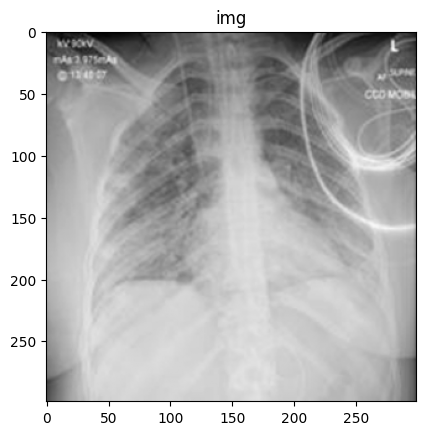

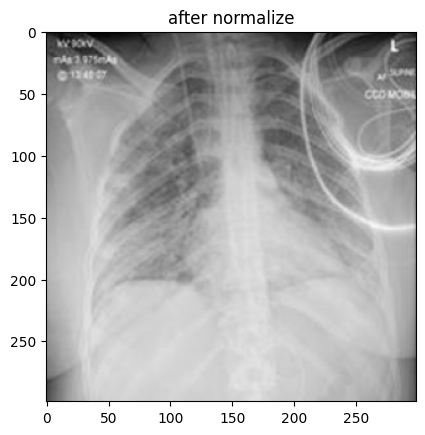

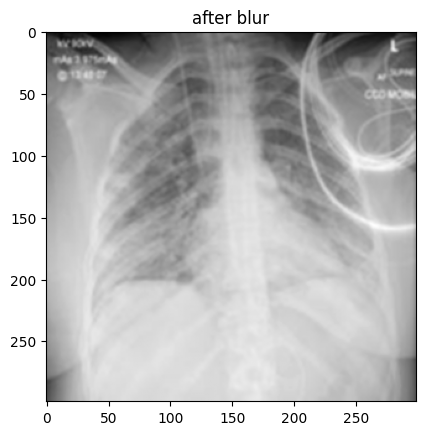

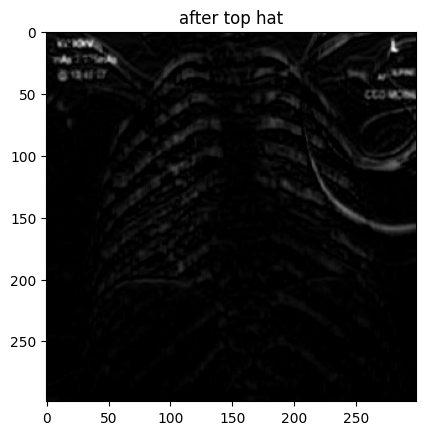

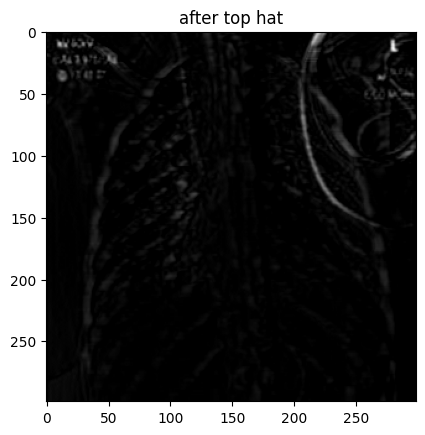

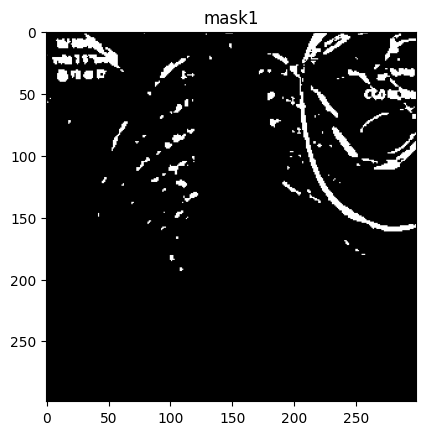

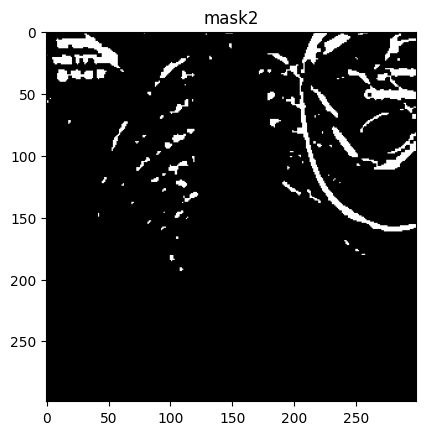

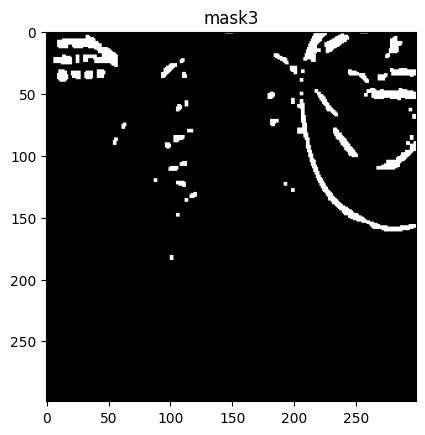

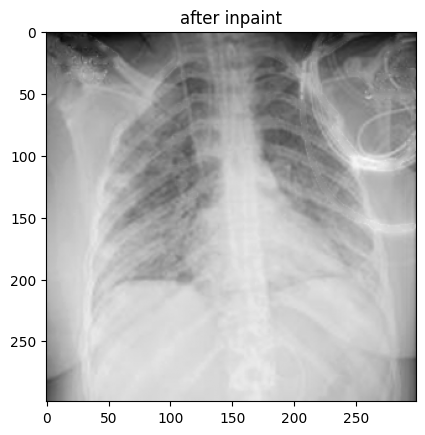

total de perte intermediaire :  5552452


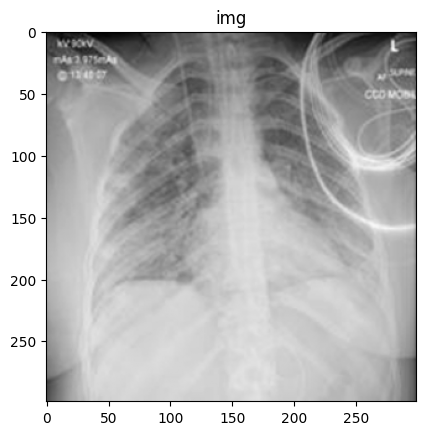

3


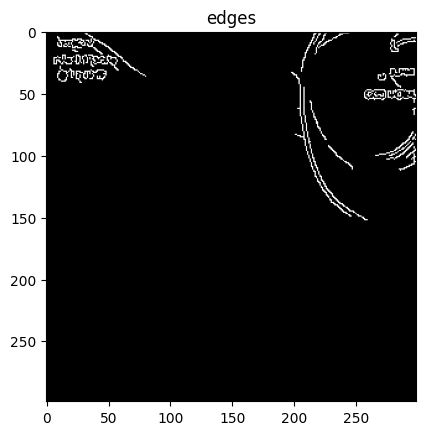

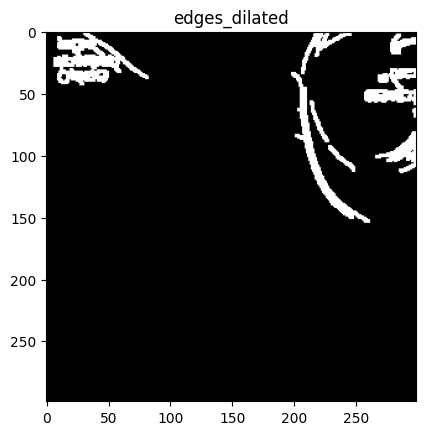

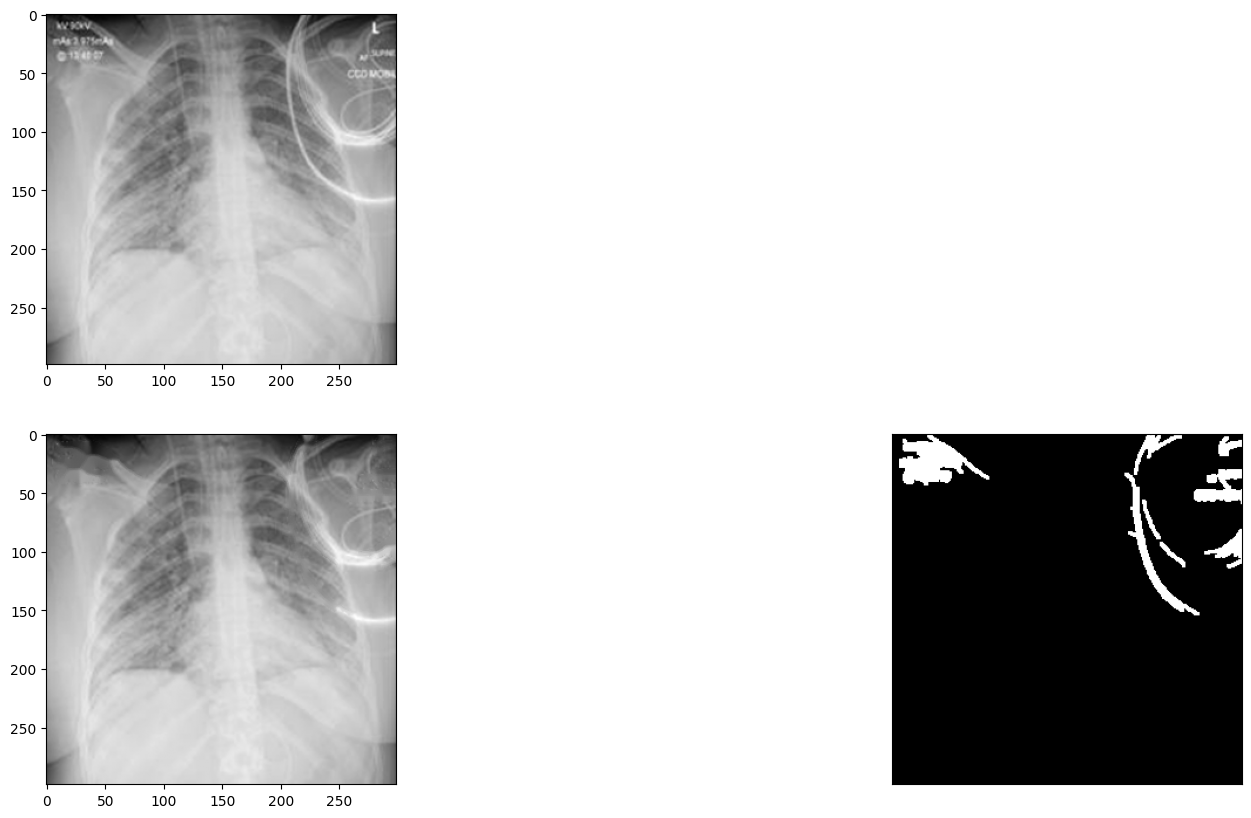

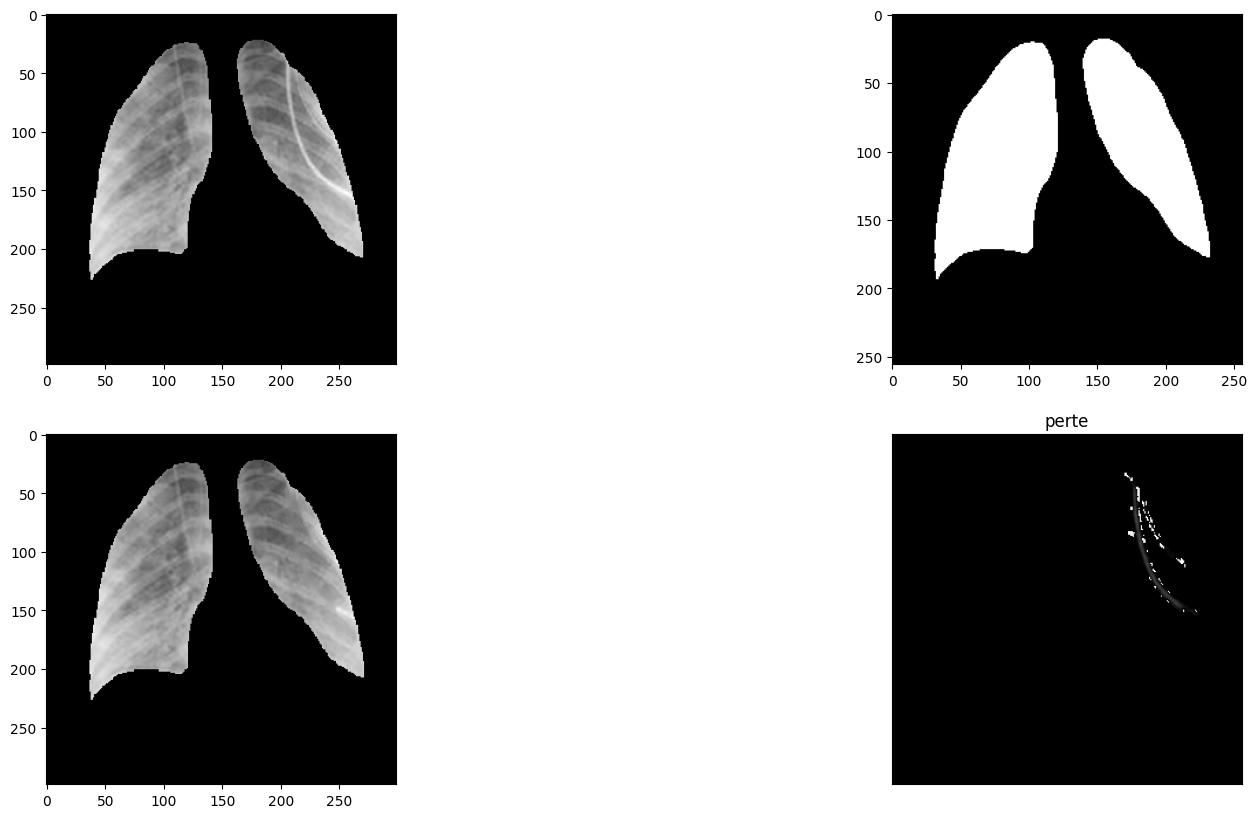

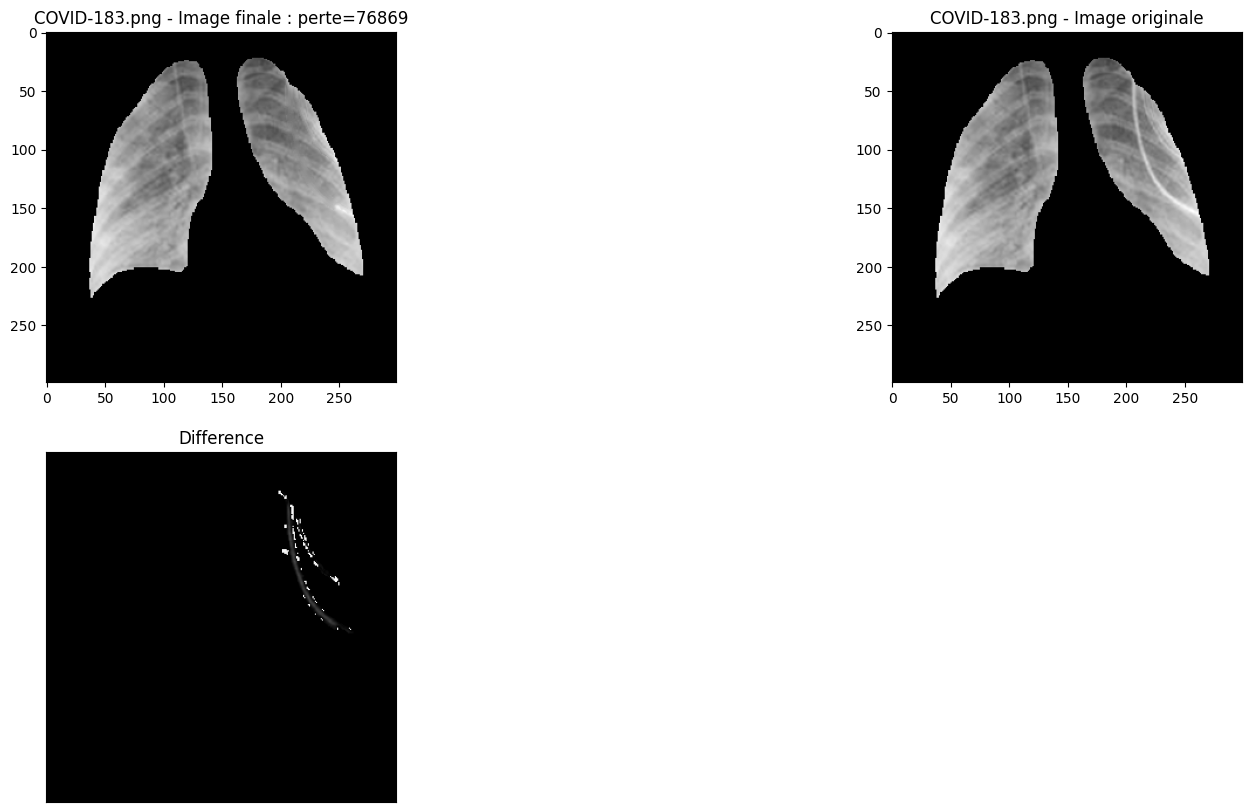

final lost liste:[{'COVID-183.png': np.uint64(76869)}]


In [8]:
#liste_test = ["COVID-3.png", "COVID-161.png", "COVID-168.png", "COVID-183.png", "COVID-193.png", "COVID-213.png", "COVID-318.png", "COVID-450.png", "COVID-481.png", "COVID-1837.png", "COVID-2560.png"]
liste_test = ["COVID-183.png"]

loss_list = []

for img in liste_test:
    print(img)

    cleaned_img_masked, original_img, loss = test_cleaner(img, debug_mode=True, loss_threshold=50000)

    loss_list.append({img:loss.sum()})
    plt.figure(figsize = (20,10))

    plt.subplot(2,2,1)
    plt.imshow(cleaned_img_masked, cmap = 'gray')
    plt.title(f"{img} - Image finale : perte={loss.sum()}")
    plt.subplot(2,2,2)
    plt.imshow(original_img, cmap = 'gray')
    plt.title(f"{img} - Image originale")
    plt.subplot(2,2,3)
    plt.imshow(loss, cmap = 'gray')
    plt.title("Difference")
    plt.xticks([])
    plt.yticks([])
    plt.show();
    
print(f"final lost liste:{loss_list}")